In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [34]:
def dateparse(x):
    if x == 'Pilot':
        x = '14/06/2017'
    return pd.datetime.strptime(x, '%d/%m/%Y')
#dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

qs = pd.read_csv('sciroom_qs.csv', skiprows=2, parse_dates=['When?'], date_parser=dateparse)

In [35]:
qs.rename(columns={'When?':'date', 'Will this be a potential talk, blog post, or nothing? ':'output_type', 
                   'Who?':'who', 'Other comments':'comments'}, inplace=True)

In [36]:
#qs["date"] = qs["date"].astype("datetime64")
qs.head()

,Name,date,Questions,output_type,comments,who
0,Przemek Ociepa,2017-06-14,"""Could machines be conscious?""",Event,Made into event 1! But what about content?,Jamal
1,Przemek Ociepa,2017-06-14,"""Are we approaching to an ecological collapse?""",Event,Loss of diversity. E.g. mass extinction,Neil
2,Philip Wiles,2017-06-14,"""Are we losing the war on disease?""",Event,Disease - illness' Medical student or (at wors...,NaN
3,Philip Wiles,2017-06-14,"""Is the nature of reality dependent on our obs...",Content: Read,Peter. At Some Point.,Peter
4,Tim Wiles,2017-06-14,"""What inventions would we not have without the...",Event / Content,Hard to make it discussiony/involving. space -...,NaN


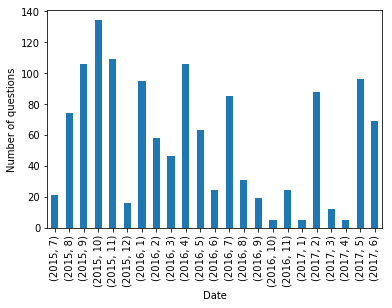

In [45]:
fig = qs[['date']].groupby([qs["date"].dt.year, qs["date"].dt.month]).count().plot(kind="bar", legend=False)
fig.set_xlabel('Date')
fig.set_ylabel('Number of questions')
plt.show()

In [46]:
biology_words = ["ecological", "disease", "nature", "plants", "animals"]
physics_words = ["space", "black holes", "star"]
chemistry_words = ["chemicals"]